In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/HateSpeechDatasetBalanced_reduced_100k.csv')

# Display the first few rows of the CSV file
df.head()


,Content,Label,clean_text
0,he don't want my surrender to my new math book...,1,he dont want my surrender to my new math book ...
1,pravi drzavnicki gov or sto god missile oh emu...,1,pravi drzavnicki gov or sto god missile oh emu...
2,i fucking hate going to my girlfriends house,0,i fucking hate going to my girlfriends house
3,asked that pretend son to b a time the son wou...,1,asked that pretend son to b a time the son wou...
4,well myself am connected to an ethnically jewi...,1,well myself am connected to an ethnically jewi...


In [2]:
df_clean = df.drop(columns=["Content"])

In [3]:
df_clean.head()

,Label,clean_text
0,1,he dont want my surrender to my new math book ...
1,1,pravi drzavnicki gov or sto god missile oh emu...
2,0,i fucking hate going to my girlfriends house
3,1,asked that pretend son to b a time the son wou...
4,1,well myself am connected to an ethnically jewi...


In [4]:
from sklearn.model_selection import train_test_split

# Split into training and temp (which will be split into validation and test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['clean_text'].tolist(), df['Label'].tolist(), test_size=0.3, random_state=42
)

# Split temp into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Testing samples: {len(test_texts)}")

Training samples: 70000
Validation samples: 15000
Testing samples: 15000


In [5]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="roberta-base")

#pipe = pipeline("fill-mask", model="distilbert/distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

#facebook/roberta-hate-speech-dynabench-r4-target
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base")


# Load model directly
#from transformers import AutoTokenizer, AutoModelForMaskedLM

#tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
#model = AutoModelForMaskedLM.from_pretrained("distilbert/distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [7]:
import tensorflow as tf
# from transformers import TFAutoModelForSequenceClassification
# from transformers import DataCollatorWithPadding
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [8]:
# Tokenize the data
def tokenize_texts(texts, tokenizer, max_length=512):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

In [9]:
train_encodings = tokenize_texts(train_texts, tokenizer)
val_encodings = tokenize_texts(val_texts, tokenizer)
test_encodings = tokenize_texts(test_texts, tokenizer)

In [10]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))


In [11]:

# Batch the datasets
batch_size = 16
train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics])

In [13]:
# Define callbacks
#callbacks = [
#    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#]

#checkpoint = [tf.keras.callbacks.ModelCheckpoint(
#    'best_model.h5',
#    save_best_only=True,
#    monitor='val_loss',
#    mode='min'
#)]

In [14]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),

    # Updated ModelCheckpoint to save in TensorFlow format
    tf.keras.callbacks.ModelCheckpoint(
        'best_model',  # Saves the model in TensorFlow's native format
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        save_format='tf'  # Save in TensorFlow's format (not HDF5)
    )
]


In [15]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[callbacks]
)

Epoch 1/10
4375/4375 [==============================] - 1148s 253ms/step - loss: 0.3635 - accuracy: 0.8360 - val_loss: 0.3035 - val_accuracy: 0.8685
Epoch 2/10
4375/4375 [==============================] - 1060s 242ms/step - loss: 0.2479 - accuracy: 0.8944 - val_loss: 0.3178 - val_accuracy: 0.8669
Epoch 3/10
4375/4375 [==============================] - 1060s 242ms/step - loss: 0.1771 - accuracy: 0.9281 - val_loss: 0.3398 - val_accuracy: 0.8765
Epoch 4/10
4375/4375 [==============================] - 1061s 243ms/step - loss: 0.1247 - accuracy: 0.9516 - val_loss: 0.3648 - val_accuracy: 0.8749


In [16]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")


938/938 [==============================] - 78s 84ms/step - loss: 0.3046 - accuracy: 0.8649
Test Accuracy: 0.8648666739463806


In [17]:
# Plot training & validation loss and accuracy
def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

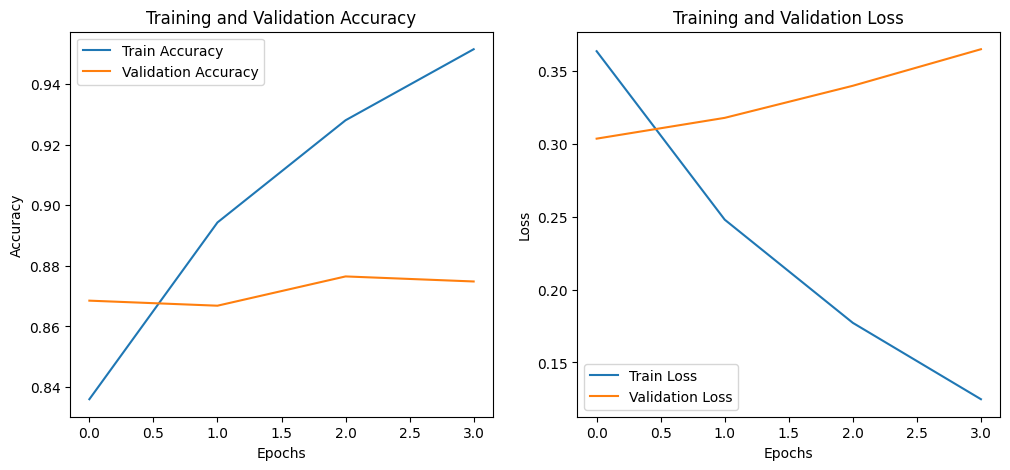

In [18]:
# Plot training history
plot_history(history)